### Video Understanding with Qwen3-VL

In this notebook, we delve into the capabilities of the **Qwen3-VL** model for video understanding tasks. Our objective is to showcase how this advanced model can be applied to various video analysis scenarios.


#### \[Setup\]

We start by loading the pre-trained `Qwen3-VL` model.

In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
OMNIFALL_ROOT="/lsdf/data/activity/fall_detection/cvhci_fall"

In [9]:
import torch

major_version, minor_version = torch.cuda.get_device_capability()
if major_version >= 8:
    print("GPU is compatible with FlashAttention")
    attn_implementation = "flash_attention_2"
else:
    print("GPU is not compatible with FlashAttention")
    attn_implementation = None

GPU is compatible with FlashAttention


In [20]:
from PIL import Image
from infreqact.inference import inference, init_qwen_model

model, processor = init_qwen_model(
    size="2B",
    attn_implementation=attn_implementation,
    cache_dir="../.cache"
)

In [11]:
from infreqact.data.video_dataset import OmnifallVideoDataset


dataset_config = {
    "video_root": f"{OMNIFALL_ROOT}/OOPS/video",
    "annotations_file": "hf://simplexsigil2/omnifall/labels/OOPS.csv",
    "split_root": "hf://simplexsigil2/omnifall/splits",
    "dataset_name": "OOPS",
    "mode": "test",  # Start with test set (smaller)
    "split": "cs",  # Cross-subject split
    "target_fps": 8.0,  # Low FPS for quick testing
    "vid_frame_count": 16,
    "data_fps": 30.0,  # OOPS videos are 30 FPS
    "ext": ".mp4",
    "fast": True,
}

print("\nDataset Configuration:")
for key, value in dataset_config.items():
    print(f"  {key}: {value}")
print("=" * 80)

# Create dataset
print("\nCreating OmnifallVideoDataset...")
try:
    dataset = OmnifallVideoDataset(**dataset_config)
    print("✓ Dataset created successfully!")
    print(f"\n{dataset}")
    print("=" * 80)

except Exception as e:
    print(f"✗ Failed to create dataset: {e}")
    import traceback
    traceback.print_exc()


Dataset Configuration:
  video_root: /lsdf/data/activity/fall_detection/cvhci_fall/OOPS/video
  annotations_file: hf://simplexsigil2/omnifall/labels/OOPS.csv
  split_root: hf://simplexsigil2/omnifall/splits
  dataset_name: OOPS
  mode: test
  split: cs
  target_fps: 8.0
  vid_frame_count: 16
  data_fps: 30.0
  ext: .mp4
  fast: True

Creating OmnifallVideoDataset...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✓ Dataset created successfully!

OmnifallVideoDataset(name='OOPS', split='cs', mode='test', videos=573, segments=2743)


In [17]:
inputs = dataset[0]

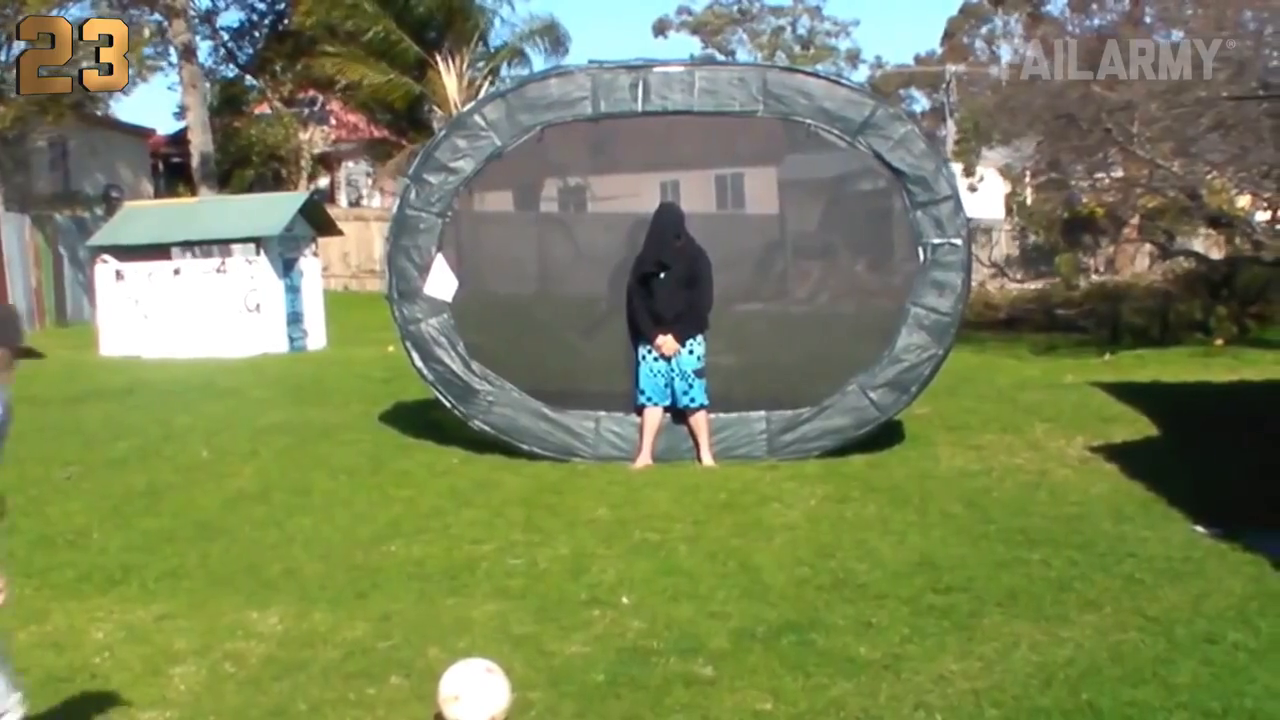

In [23]:
frames = [Image.fromarray(frame) for frame in inputs["video"]]
frames[0]

In [30]:
%%time
result, inputs = inference(
    frames,
    "Briefly describe this video, focusing on the (infrequent) actions a person does, e.g. falling down or examining something",
    model,
    processor,
    max_pixels=500 * 32 * 32,
    return_inputs=True,
)

Time taken for process_vision_info: 0.06 seconds
Video input shape: torch.Size([16, 3, 512, 896])
Time taken for model.generate: 51.93 seconds
CPU times: user 53.4 s, sys: 814 ms, total: 54.2 s
Wall time: 52 s


In [ ]:
result

'A man kicks a ball towards a trampoline, but the ball hits the trampoline and the man is thrown backward.'

### 1. Using Video URL - Local Inference

In [ ]:
from typing import Annotated

from json_repair import repair_json
from pydantic import BaseModel, Field, ValidationInfo, field_validator, model_validator


class ActionSegment(BaseModel):
    label: Annotated[int, Field(ge=0, le=15)]
    description: str
    start_time: float
    end_time: float

    @field_validator("end_time", mode="after")
    @classmethod
    def end_time_gt_start_time(cls, value: float, info: ValidationInfo):
        if value <= info.data["start_time"]:
            raise ValueError("end_time must be greater than start_time")
        return value


class ActionDetection(BaseModel):
    segments: list[ActionSegment]

    @model_validator(mode="after")
    def check_sorted_and_non_overlapping(self):
        segs = sorted(self.segments, key=lambda s: s.start_time)
        for i in range(len(segs) - 1):
            if segs[i].end_time > segs[i + 1].start_time:
                raise ValueError(
                    f"Segments overlap between index {i} and {i + 1}: "
                    f"{segs[i].end_time} > {segs[i + 1].start_time}"
                )
        self.segments = segs  # assign sorted version
        return self

In [ ]:
prompt = """
You are an expert in human activity recognition. Given a short video, segment it into temporally into continuous intervals, labeling each interval with one of the activity classes.

TASK:
Perform full temporal segmentation of the video into labeled segments. Each segment should have:
- "label": the activity label ID (0 to 9, see below),
- "start_time": when the activity starts (in seconds),
- "end_time": when it ends (in seconds),
- "description": short description of what happens in this segment

ACTIVITY LABELS:
0|walk - Move around, including jogging and running and "drunk walking", but only if it is not part of some special exercise like pulling your knees up. Not when pushing a large object like a chair, but included carrying something small like an apple.
1|fall - The act of falling (from any previous state). Includes falling on a bed, if the process is not a controlled lying down with arms as support.
2|fallen - Being on the ground or a mattress after a fall.
3|sit_down - Sitting down on bed or chair or ground.
4|sitting - Sitting on bed or chair or ground.
5|lie_down - Lying down intentionally (in contrast to a fall) on ground or bed.
6|lying - Being in a lying position (in bed or on the ground) after intentionally getting into that position.
7|stand_up - Standing up from a fallen state, from lying or sitting. Includes getting from lying position into sitting position.
8|standing - Standing around without walking.
9|other - Any other activity, including e.g. walking while pushing an object like a chair.p

DEFINITIONS:
- Transient actions (e.g., sit_down, fall, lie_down, stand_up) mark short events.
- Static states (e.g., sitting, lying, standing, fallen) indicate sustained postures.
- “fall” means an unintentional loss of balance leading to a person ending up on the ground.
- “fallen” refers to the state after a fall when the person remains on the ground.
- “other” should be used for actions not fitting any defined class.

Focus on the activity labels given. If a scene changes slightly, but the label is the same, merge segments so that no segment has the same label as the previous one.

OUTPUT JSON FORMAT: (for example)
{
    segments: [
    {
        "label": 0-9,
        "start_time": float,
        "end_time": float,
        "description": "some text"
    },
    ...
    ]
}
"""

In [ ]:
response = inference(path, prompt, sample_fps=sample_fps, target_fps=10, max_pixels=200 * 500)
display(Markdown(response))
repaired = repair_json(response)

INFO:qwen_vl_utils.vision_process:decord:  video_path='/content/drive/MyDrive/oops_fall/falls/BeeKeeperBusiness-FailsoftheWeekNovember2018_FailArmy18.mp4', total_frames=264, video_fps=29.97, time=1.455s


Time taken for process_vision_info: 3.52 seconds
Video input shape: torch.Size([88, 3, 224, 416])
Time taken for model.generate: 184.85 seconds


```json
{
    "segments": [
        {
            "label": 0,
            "start_time": 0.0,
            "end_time": 0.9,
            "description": "A woman is standing by the water's edge, holding a pole and looking at the rocks."
        },
        {
            "label": 0,
            "start_time": 0.9,
            "end_time": 5.8,
            "description": "The woman continues to stand by the water's edge, holding the pole and looking at the rocks."
        },
        {
            "label": 1,
            "start_time": 5.8,
            "end_time": 6.1,
            "description": "The woman takes a step forward and falls forward, losing her balance."
        },
        {
            "label": 2,
            "start_time": 6.1,
            "end_time": 6.3,
            "description": "The woman is on the ground after falling, with her body lying on the rocks."
        },
        {
            "label": 3,
            "start_time": 6.3,
            "end_time": 7.2,
            "description": "The woman is lying on the ground, with her body still in a relaxed position."
        },
        {
            "label": 4,
            "start_time": 7.2,
            "end_time": 7.5,
            "description": "The woman is sitting on the ground, with her body still in a relaxed position."
        },
        {
            "label": 5,
            "start_time": 7.5,
            "end_time": 8.0,
            "description": "The woman is lying down on the ground, with her body still in a relaxed position."
        },
        {
            "label": 6,
            "start_time": 8.0,
            "end_time": 8.3,
            "description": "The woman is lying on the ground, with her body still in a relaxed position."
        },
        {
            "label": 7,
            "start_time": 8.3,
            "end_time": 8.5,
            "description": "The woman is standing up from the ground, with her body still in a relaxed position."
        },
        {
            "label": 8,
            "start_time": 8.5,
            "end_time": 9.0,
            "description": "The woman is standing still, with her body still in a relaxed position."
        }
    ]
}
```

In [ ]:
result = ActionDetection.model_validate_json(repaired)
result

ActionDetection(segments=[ActionSegment(label=0, description='A woman is standing on a concrete path next to a body of water, looking at the rocks and the water.', start_time=0.0, end_time=3.5), ActionSegment(label=1, description='The woman takes a step forward and then falls backward into the water.', start_time=3.5, end_time=6.5), ActionSegment(label=2, description='The woman is on the ground after falling into the water.', start_time=6.5, end_time=7.0)])